In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import time
from itertools import compress
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import random
import seaborn as sn
import matplotlib.pyplot as plt

In [2]:
tx="asset_transaction_history.csv"
assets="assets.csv"
clients="clients.csv"
deals="deals2.csv"

assets=pd.read_csv(assets)
clients=pd.read_csv(clients)
tx=pd.read_csv(tx)
deals=pd.read_csv(deals)

tx.columns=list(tx)[:-1]+["AssetID"]

/usr/local/Anaconda3-5.1.0/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/Anaconda3-5.1.0/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
def NA_randreplace(df):
    #Replaces NAs IN-PLACE by random selection
    for i in list(df):
        rows=pd.isnull(assets.loc[:,i]) #NA detector
        index=rows.loc[rows==True].index #filter for NAs
        Nan_Index=assets.loc[index,i].index #Targeted rows for replacement
        
        k=df.loc[:,i].isna().sum() #number of NAs to fill
        not_nas=list(df.loc[df.loc[:,i].notna(),i]) #Create Not-NAs pool to sample
        fill_list=random.choices(not_nas,k=k) #randomly select
        
        df.loc[Nan_Index,i]=fill_list #replace

In [4]:
#Asset columns
screen1 =['AssetID',\
          'City',\
          'State',\
          'CountryID',\
          'PropertyType',\
          'PropertyTypeGroup',\
          'YearBuilt',\
          'AssetLatitude',\
          'AssetLongitude',\
          'LandAreaInAcres',\
          'NumberofFloors',\
          'NumberofBuildings',\
          'YearRenovated',\
          'Size_Acres',\
          'Lat_city',\
          'Long_city',\
          'IsGateway',\
          'Region',\
          'Size_Sqft',\
          'Size_Units',\
          'Class',\
          'Market_name']


#Client columns
screen2 = ['ClientID',\
 'Client_IsForeign',\
 'Client_InvestorType',\
 'Client_LenderBook',\
 'Client_BuyerBook',\
 'Client_SFBook',\
 'Client_NSBook',\
 'Client_HFFSBook']


In [5]:
assets=assets.loc[assets.CountryID==1,screen1]
clients=clients.loc[:,screen2]

In [6]:
tx=tx.merge(assets,on="AssetID")
tx=tx.merge(deals.loc[deals.Stage=="Completed and Paid",],on="DealID")
tx=tx.merge(clients,on="ClientID")
tx.loc[:,"AccountingDate"]=[datetime.strptime(x, '%m/%d/%Y') for x in tx.loc[:,"AccountingDate"]]
tx.sort_values(by='AccountingDate',ascending=False,inplace=True)
tx.index=range(len(tx))
tx["y"] = 0 #create column
assets["y"] = 0 #create column

In [7]:
np.around(assets.describe(),1)

,AssetID,CountryID,YearBuilt,AssetLatitude,AssetLongitude,LandAreaInAcres,NumberofBuildings,YearRenovated,Size_Acres,Lat_city,Long_city,IsGateway,Size_Sqft,Size_Units,y
count,183945.0,183945.0,142781.0,181997.0,181997.0,97778.0,73421.0,32190.0,112844.0,171388.0,171388.0,183945.0,1.483650e+05,65440.0,183945.0
mean,96566.8,1.0,1981.9,36.6,-93.6,700.6,3.7,2000.9,1069.9,36.5,-94.3,0.2,4.747770e+05,1169.8,0.0
std,60291.7,0.0,27.4,5.3,17.9,21817.6,14.9,512.5,33672.3,5.3,17.2,0.4,2.046154e+07,18681.0,0.0
min,1.0,1.0,-200.0,-36.9,-159.7,-1.0,0.0,223.0,-1.0,19.6,-159.7,0.0,0.000000e+00,0.0,0.0
25%,45170.0,1.0,1972.0,33.0,-111.9,1.6,1.0,1992.0,1.7,32.9,-111.9,0.0,4.895800e+04,81.0,0.0
50%,89720.0,1.0,1987.0,37.4,-88.0,5.0,1.0,2001.0,5.1,36.7,-89.6,0.0,1.044500e+05,151.0,0.0
75%,152258.0,1.0,2000.0,40.7,-79.0,12.0,2.0,2006.0,12.4,40.7,-80.1,0.0,2.205830e+05,265.0,0.0
max,205293.0,1.0,2024.0,64.9,150.8,2246389.0,1993.0,93912.0,6594548.0,64.8,-67.8,1.0,3.979925e+09,1837074.0,0.0


In [8]:
#Clean unreasonable outliers
assets.loc[assets.YearBuilt<1700,"YearBuilt"]=np.nan #YearBuilt before 1700
assets.loc[assets.LandAreaInAcres<0,"LandAreaInAcres"]=np.nan #-1 acres
assets.loc[assets.Size_Acres<0,"Size_Acres"]=np.nan
assets.loc[assets.YearRenovated	<1900,"YearRenovated"]=np.nan #unreasonable years
assets.loc[assets.YearRenovated	>2025,"YearRenovated"]=np.nan

In [14]:
transactions=np.unique(tx.AssetID) #8229
assset=np.unique(assets.AssetID) #177120

print("unique properties listed in asset_transactions: ",len(transactions))
print("unique properties listed in assets: ",len(assset))
print("Assets represented in asset_transactions ONLY: ",len([i for i in transactions if i not in assset])) #NO asset IDs are in tx alone
print("Assets represented in assets ONLY: ",len([i for i in assset if i not in transactions])) #168891/177120 or ~11k in assets alone

unique properties listed in asset_transactions:  8229
unique properties listed in assets:  177120
Assets represented in asset_transactions ONLY:  0
Assets represented in assets ONLY:  168891


In [15]:
#NA Analysis

threshold=.25

#Drop predictors which cannot be well imputed (i.e. too many NAs!)
screen_hiNA=assets.columns.where(assets.isnull().sum()/len(assets)>threshold)
screen_hiNA=list(screen_hiNA[~screen_hiNA.isnull()])
print("Variables dropped:","\n",screen_hiNA,"\n")

assets=assets.drop(screen_hiNA,axis=1)

print("Current NAs %:","\n",round(assets.isnull().sum()/len(assets),3),"\n")

Variables dropped: 
 ['LandAreaInAcres', 'NumberofFloors', 'NumberofBuildings', 'YearRenovated', 'Size_Acres', 'Size_Units', 'Class'] 

Current NAs %: 
 AssetID              0.000
City                 0.000
State                0.000
CountryID            0.000
PropertyType         0.000
PropertyTypeGroup    0.026
YearBuilt            0.224
AssetLatitude        0.011
AssetLongitude       0.011
Lat_city             0.068
Long_city            0.068
IsGateway            0.000
Region               0.001
Size_Sqft            0.193
Market_name          0.037
y                    0.000
dtype: float64 



In [16]:
#Imputation: random selection

print("Current Nas",np.sum(assets.isnull().sum()),"\n")

NA_randreplace(assets)
            
print("Nas remaining",np.sum(assets.isnull().sum()))

Current Nas 117318 

Nas remaining 0


In [17]:
#Split & Encode

#Train: start-EOY2017
#Test: 2018
train_threshold=np.datetime64('2018-01-01')
test_threshold=np.datetime64('2019-01-01')
tx.loc[tx.loc[:,"AccountingDate"]>train_threshold,'y']=1 #Set tx's y values based on threshold date

#Transfer values to Assets
Sold_IDs=list(tx.loc[tx.loc[:,"y"]>0,'AssetID']) #Asset IDs of y=1 properties
for i in Sold_IDs:
    assets.loc[assets.AssetID ==i,"y"] =1

    

#Split train and test based on date
filter_test=tx.loc[:,"AccountingDate"]>=test_threshold
IDs_test=tx.loc[filter_test,"AssetID"]
test=assets.loc[assets.AssetID.isin(IDs_test),:] #contains only recent properties sold (only recent y=1's)
#...Rest are train...
train=assets.loc[~assets.AssetID.isin(IDs_test),:] #All tx's BEFORE test threshold are train 

In [18]:
#Complete constructing test set by adding rest of properties (y=0's)
tx.loc[tx.loc[:,"AccountingDate"]<test_threshold,'y']=0 #zero out y's before test threshold date
assets2=assets.copy()
assets2.loc[:,"y"] =0 #zero out y's 
Sold_IDs=list(tx.loc[tx.loc[:,"y"]>0,'AssetID']) #Collect IDs of properties sold (y=1)
rest=assets2.loc[~assets.AssetID.isin(Sold_IDs),:] #filter out y=1's
test=pd.concat((test,rest),axis=0)

In [19]:
assets.shape

(183945, 16)

In [20]:
train.shape #excludes test threshold samples

(183873, 16)

In [21]:
test.shape #includes all samples

(183945, 16)

In [22]:
#ENCODE
#Drop non-predictor columns
asides=['AssetID','City','CountryID']
train=train.drop(asides,axis=1)

train=pd.get_dummies(train)

print("train post-codified number of columns: ",len(list(train)))   


train post-codified number of columns:  376


In [24]:
#Split train into train + validate
train_1=train.loc[train.y==1,:]
train_0=train.loc[train.y==0,:]

#Due to imbalanced dataset, we split y=1 and y=0 BEFORE upsampling
train_1, val_1 = train_test_split(train_1, test_size = 0.30, random_state = 43)
train_0, val_0 = train_test_split(train_0, test_size = 0.30, random_state = 43)

val=pd.concat((val_1,val_0))

In [26]:
#Upsampling train - targeting a 50/50 split between y=1 and y=0

#Assess imbalance
print("Before upsampling, y=1: ",len(train_1))
print("Before upsampling,y=0: ",len(train_0),"\n")

#Upsample y=1 to match count of y=0 using random selection
train_1_indexes = np.random.choice(train_1.index, size=len(train_0)-len(train_1), replace=True)
train_1_up=train_1.loc[train_1_indexes,:]
train_1=pd.concat((train_1,train_1_up))

print("After upsampling,y=1: ",len(train_1))
print("After upsampling,y=0: ",len(train_0),"\n")

train=pd.concat((train_1,train_0))

print("Total upsampled train length: ",len(train))

Before upsampling, y=1:  758
Before upsampling,y=0:  127953 

After upsampling,y=1:  127953
After upsampling,y=0:  127953 

Total upsampled train length:  255906


In [27]:
#Predictors
x_train=train.drop(columns='y')
x_val=val.drop(columns='y')

#Target
y_train = train.loc[:,"y"]
y_val= val.loc[:,"y"]

In [28]:
#Normalize data 0-1

#Save column names
cols=list(x_train)

# #Scale the data
std_scale = MinMaxScaler().fit(x_train)
x_train = std_scale.transform(x_train) 
x_val = std_scale.transform(x_val) 

#Return to pandas dataframe from numpy array
x_train=pd.DataFrame(x_train)
x_train.columns=cols
x_val=pd.DataFrame(x_val)
x_val.columns=cols

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score

In [38]:
logit=LogisticRegression(penalty='l2', 
                         dual=False, 
                         tol=0.0001, 
                         C=1.0, 
                         fit_intercept=True, 
                         intercept_scaling=1, 
                         class_weight=None, 
                         random_state=None, 
                         solver='liblinear', 
                         max_iter=100, 
                         multi_class='ovr', 
                         verbose=0, 
                         warm_start=False, 
                         n_jobs=1)

logit.fit(x_train,y_train)
print("Train accuracy: ",logit.score(x_train,y_train))
print("Validation accuracy: ",logit.score(x_val,y_val),"\n")
pred=logit.predict(x_val)
print(confusion_matrix(y_val, pred),"\n")


probs=logit.predict_proba(x_val)[:,1] #SCREEN FOR PREDICTION OF y=1 PROBS
print("ROC AUC score")
print(roc_auc_score(y_val, probs),"\n")

# #CROSS VALIDATION
scores = cross_val_score(logit, x_train, y_train, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Train accuracy:  0.7017264151680696
Validation accuracy:  0.6626481998477213 

[[36324 18513]
 [   96   229]] 

ROC AUC score
0.749363442145323 



KeyboardInterrupt: 

In [59]:
mdl=DecisionTreeClassifier(criterion='gini', 
                       splitter='best', 
                       max_depth=10, 
                       min_samples_split=2, 
                       min_samples_leaf=1, 
                       min_weight_fraction_leaf=0.0, 
                       max_features=None, 
                       random_state=None, 
                       max_leaf_nodes=None, 
                       min_impurity_decrease=0.0, 
                       min_impurity_split=None, 
                       class_weight=None, 
                       presort=False)

#create a dictionary of parameters for grid search 
param_grid = {'max_features':[10,25,50,150],
'max_depth':[10,25,50],
'random_state':[11]}

#--------------------------------------
mygrid = GridSearchCV(mdl, param_grid, cv = 5, scoring = 'roc_auc',refit = True, n_jobs=-1, verbose = 5)
mygrid.fit(x_train, y_train)

print("The following are the most optimal parameters found within my grid search:","\n")
print(mygrid.best_params_,"\n" )
print("This represents the model to use:","\n")
print(mygrid.best_estimator_,"\n")

#Fit to best parameters
mytree=mygrid.best_estimator_
mytree.fit(x_train, y_train)

print("Train accuracy: ",mytree.score(x_train,y_train))
print("Validation accuracy: ",mytree.score(x_val,y_val),"\n")
pred=mytree.predict(x_val)
print(confusion_matrix(y_val, pred),"\n")


# #CROSS VALIDATION
scores = cross_val_score(mytree, x_train, y_train, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] max_depth=10, max_features=10, random_state=11 ..................
[CV] max_depth=10, max_features=10, random_state=11 ..................
[CV]  max_depth=10, max_features=10, random_state=11, score=0.6702106067818389, total=   1.6s
[CV]  max_depth=10, max_features=10, random_state=11, score=0.6417655618101069, total=   1.6s
[CV] max_depth=10, max_features=10, random_state=11 ..................
[CV] max_depth=10, max_features=10, random_state=11 ..................
[CV]  max_depth=10, max_features=10, random_state=11, score=0.6406375555327567, total=   1.7s
[CV] max_depth=10, max_features=10, random_state=11 ..................
[CV]  max_depth=10, max_features=10, random_state=11, score=0.6528997564473349, total=   1.8s


[Parallel(n_jobs=-1)]: Done   4 out of  60 | elapsed:   10.7s remaining:  2.5min


[CV] max_depth=10, max_features=25, random_state=11 ..................
[CV]  max_depth=10, max_features=10, random_state=11, score=0.6696035271385837, total=   1.6s
[CV] max_depth=10, max_features=25, random_state=11 ..................
[CV]  max_depth=10, max_features=25, random_state=11, score=0.7229719244416152, total=   1.9s
[CV] max_depth=10, max_features=25, random_state=11 ..................
[CV]  max_depth=10, max_features=25, random_state=11, score=0.7341163701781496, total=   1.7s
[CV] max_depth=10, max_features=25, random_state=11 ..................
[CV]  max_depth=10, max_features=25, random_state=11, score=0.7057672620959864, total=   1.7s
[CV] max_depth=10, max_features=25, random_state=11 ..................
[CV]  max_depth=10, max_features=25, random_state=11, score=0.6993521764818439, total=   1.7s
[CV] max_depth=10, max_features=50, random_state=11 ..................
[CV]  max_depth=10, max_features=25, random_state=11, score=0.7213684891198431, total=   1.9s
[CV] max_d

[Parallel(n_jobs=-1)]: Done  17 out of  60 | elapsed:   35.9s remaining:  1.5min


[CV] max_depth=10, max_features=150, random_state=11 .................
[CV]  max_depth=10, max_features=150, random_state=11, score=0.8066991701278108, total=   3.8s
[CV] max_depth=25, max_features=10, random_state=11 ..................
[CV] max_depth=25, max_features=10, random_state=11 ..................
[CV]  max_depth=10, max_features=150, random_state=11, score=0.8230892278682644, total=   4.0s
[CV]  max_depth=10, max_features=150, random_state=11, score=0.8323221209620979, total=   3.6s
[CV]  max_depth=25, max_features=10, random_state=11, score=0.9124823852112307, total=   2.2s
[CV] max_depth=25, max_features=10, random_state=11 ..................
[CV] max_depth=25, max_features=10, random_state=11 ..................
[CV]  max_depth=25, max_features=10, random_state=11, score=0.9176490048704146, total=   2.3s
[CV]  max_depth=25, max_features=10, random_state=11, score=0.9016129428305174, total=   2.3s
[CV] max_depth=25, max_features=10, random_state=11 ..................
[CV]  m

[Parallel(n_jobs=-1)]: Done  30 out of  60 | elapsed:   57.0s remaining:   57.0s


[CV] max_depth=25, max_features=50, random_state=11 ..................
[CV]  max_depth=25, max_features=50, random_state=11, score=0.9821694719496875, total=   3.3s
[CV] max_depth=25, max_features=50, random_state=11 ..................
[CV]  max_depth=25, max_features=50, random_state=11, score=0.9845302280916689, total=   3.6s
[CV] max_depth=25, max_features=50, random_state=11 ..................
[CV]  max_depth=25, max_features=50, random_state=11, score=0.9808882352399468, total=   3.9s
[CV] max_depth=25, max_features=150, random_state=11 .................
[CV]  max_depth=25, max_features=50, random_state=11, score=0.9814760194005298, total=   3.5s
[CV] max_depth=25, max_features=150, random_state=11 .................
[CV]  max_depth=25, max_features=50, random_state=11, score=0.9894810842392304, total=   3.5s
[CV] max_depth=25, max_features=150, random_state=11 .................
[CV] max_depth=25, max_features=150, random_state=11 .................
[CV]  max_depth=25, max_features=

[Parallel(n_jobs=-1)]: Done  43 out of  60 | elapsed:  1.3min remaining:   30.8s


[CV] max_depth=50, max_features=10, random_state=11 ..................
[CV]  max_depth=50, max_features=10, random_state=11, score=0.9917789125447565, total=   2.5s
[CV] max_depth=50, max_features=25, random_state=11 ..................
[CV]  max_depth=50, max_features=10, random_state=11, score=0.9967137898086594, total=   2.5s
[CV] max_depth=50, max_features=25, random_state=11 ..................
[CV] max_depth=50, max_features=25, random_state=11 ..................
[CV]  max_depth=50, max_features=25, random_state=11, score=0.9971835615742568, total=   3.0s
[CV]  max_depth=50, max_features=25, random_state=11, score=0.9971406816981984, total=   2.6s
[CV] max_depth=50, max_features=25, random_state=11 ..................
[CV] max_depth=50, max_features=25, random_state=11 ..................
[CV]  max_depth=50, max_features=25, random_state=11, score=0.996714668862188, total=   2.9s
[CV] max_depth=50, max_features=50, random_state=11 ..................
[CV]  max_depth=50, max_features=2

[Parallel(n_jobs=-1)]: Done  56 out of  60 | elapsed:  1.7min remaining:    7.4s


[CV] max_depth=50, max_features=150, random_state=11 .................
[CV]  max_depth=50, max_features=150, random_state=11, score=0.9968076709493288, total=   5.6s
[CV]  max_depth=50, max_features=150, random_state=11, score=0.9967041939690265, total=   5.4s
[CV]  max_depth=50, max_features=150, random_state=11, score=0.9967953445997629, total=   4.3s
[CV]  max_depth=50, max_features=150, random_state=11, score=0.9970232470705802, total=   5.7s


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.8min finished


The following are the most optimal parameters found within my grid search: 

{'max_depth': 50, 'max_features': 25, 'random_state': 11} 

This represents the model to use: 

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
            max_features=25, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=11,
            splitter='best') 

Train accuracy:  0.9986166795620267
Validation accuracy:  0.9875095174214132 

[[54425   412]
 [  277    48]] 

Accuracy: 0.99 (+/- 0.01)


In [60]:
#Feature importances
imps=pd.DataFrame(mytree.feature_importances_)
imps.index=cols
imps=imps.sort_values(by=0,axis=0,ascending=False)
imps.iloc[0:15]

,0
AssetLongitude,0.173099
Size_Sqft,0.134903
YearBuilt,0.130379
AssetLatitude,0.104263
Lat_city,0.095199
Long_city,0.063136
State_NY,0.016989
Region_West,0.015719
PropertyTypeGroup_Healthcare,0.015432
State_TX,0.015003


In [36]:
#Random forest + Grid search + Cross Validation

#create base model 
mdl=RandomForestClassifier(n_estimators=2, 
                           criterion='gini', 
                           max_depth=None, 
                           min_samples_split=2, 
                           min_samples_leaf=1, 
                           min_weight_fraction_leaf=0.0, 
                           max_features='auto', 
                           max_leaf_nodes=None, 
                           min_impurity_decrease=0.0, 
                           min_impurity_split=None, 
                           bootstrap=True, 
                           oob_score=False, 
                           n_jobs=-1, 
                           random_state=None, 
                           verbose=0, 
                           warm_start=False, 
                           class_weight=None)

#create a dictionary of parameters for grid search 
param_grid = {'n_estimators':[5, 10, 25],
'max_features':[25,50,200],
'max_depth':[25,50,75],
'random_state':[11]}

#--------------------------------------
mygrid = GridSearchCV(mdl, param_grid, cv = 5, scoring = 'roc_auc',refit = True, n_jobs=-1, verbose = 5)
mygrid.fit(x_train, y_train)

print("The following are the most optimal parameters found within my grid search:","\n")
print(mygrid.best_params_,"\n" )
print("This represents the model to use:","\n")
print(mygrid.best_estimator_,"\n")

#Fit to best parameters
randforest=mygrid.best_estimator_
randforest.fit(x_train, y_train)

print("Train accuracy: ",randforest.score(x_train,y_train))
print("Validation accuracy: ",randforest.score(x_val,y_val),"\n")
pred=randforest.predict(x_val)
print(confusion_matrix(y_val, pred),"\n")


# #CROSS VALIDATION
scores = cross_val_score(randforest, x_train, y_train, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 41.7min finished


The following are the most optimal parameters found within my grid search: 

{'max_depth': 50, 'max_features': 50, 'n_estimators': 25, 'random_state': 11} 

This represents the model to use: 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features=50, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=-1,
            oob_score=False, random_state=11, verbose=0, warm_start=False) 

Train accuracy:  0.9999648308363227
Validation accuracy:  0.9935825387041805 

[[54764    73]
 [  281    44]] 

Accuracy: 1.00 (+/- 0.00)


In [37]:
mdl=LinearSVC(penalty='l2', 
              loss='squared_hinge', 
              dual=True, 
              tol=0.0001, 
              C=1.0, 
              multi_class='ovr', 
              fit_intercept=True, 
              intercept_scaling=1, 
              class_weight=None, 
              verbose=0, 
              random_state=None, 
              max_iter=1000)
       
    
#create a dictionary of parameters for grid search 
param_grid = {'tol':[0.001, 0.0001],
'max_iter':[100,250],
'random_state':[11]}

#--------------------------------------
mygrid = GridSearchCV(mdl, param_grid, cv = 5, scoring = 'roc_auc',refit = True, n_jobs=-1, verbose = 5)
mygrid.fit(x_train, y_train)

print("The following are the most optimal parameters found within my grid search:","\n")
print(mygrid.best_params_,"\n" )
print("This represents the model to use:","\n")
print(mygrid.best_estimator_,"\n")

#Fit to best parameters
SVC=mygrid.best_estimator_
SVC.fit(x_train, y_train)

print("Train accuracy: ",SVC.score(x_train,y_train))
print("Validation accuracy: ",SVC.score(x_val,y_val),"\n")
pred=SVC.predict(x_val)
print(confusion_matrix(y_val, pred),"\n")


# probs=SVC.predict_proba(x_val) #SCREEN FOR PREDICTION OF y=1 PROBS
# print("ROC AUC score")
# print(roc_auc_score(y_val, probs),"\n")


# #CROSS VALIDATION
scores = cross_val_score(SVC, x_train, y_train, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:  2.6min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:  6.2min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  8.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  8.8min finished


The following are the most optimal parameters found within my grid search: 

{'max_iter': 100, 'random_state': 11, 'tol': 0.001} 

This represents the model to use: 

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=100,
     multi_class='ovr', penalty='l2', random_state=11, tol=0.001,
     verbose=0) 

Train accuracy:  0.7039655185888568
Validation accuracy:  0.6614154671694282 

[[36256 18581]
 [   96   229]] 

Accuracy: 0.70 (+/- 0.01)


In [38]:
mdl=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), 
                         n_estimators=1, 
                         learning_rate=1.0, 
                         algorithm='SAMME.R', 
                         random_state=None)


#create a dictionary of parameters for grid search 
param_grid = {'base_estimator':[logit,DecisionTreeClassifier(max_depth=5)],
'n_estimators':[2,5,10],
'random_state':[11]}

#--------------------------------------
mygrid = GridSearchCV(mdl, param_grid, cv = 5, scoring = 'roc_auc',refit = True, n_jobs=-1, verbose = 5)
mygrid.fit(x_train, y_train)

print("The following are the most optimal parameters found within my grid search:","\n")
print(mygrid.best_params_,"\n" )
print("This represents the model to use:","\n")
print(mygrid.best_estimator_,"\n")

#Fit to best parameters
boost=mygrid.best_estimator_
boost.fit(x_train, y_train)

print("Train accuracy: ",boost.score(x_train,y_train))
print("Validation accuracy: ",boost.score(x_val,y_val),"\n")
pred=boost.predict(x_val)
print(confusion_matrix(y_val, pred),"\n")


# probs=SVC.predict_proba(x_val) #SCREEN FOR PREDICTION OF y=1 PROBS
# print("ROC AUC score")
# print(roc_auc_score(y_val, probs),"\n")


# #CROSS VALIDATION
scores = cross_val_score(boost, x_train, y_train, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   56.0s
[Parallel(n_jobs=-1)]: Done  22 out of  30 | elapsed: 15.9min remaining:  5.8min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 17.1min finished


The following are the most optimal parameters found within my grid search: 

{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), 'n_estimators': 10, 'random_state': 11} 

This represents the model to use: 

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=10, random_state=11) 



In [39]:
mdl=BaggingClassifier(base_estimator=mytree,  
                  n_estimators=2, #How many to ensemble?
                  max_samples=1.0, 
                  max_features=1.0, 
                  bootstrap=True, 
                  bootstrap_features=False, 
                  oob_score=False, 
                  warm_start=False, 
                  n_jobs=-1, 
                  random_state=1, 
                  verbose=0)

#create a dictionary of parameters for grid search 
param_grid = {'base_estimator':[DecisionTreeClassifier(max_depth=5)],
'n_estimators':[2,5,10],
'random_state':[11]}

#--------------------------------------
mygrid = GridSearchCV(mdl, param_grid, cv = 5, scoring = 'roc_auc',refit = True, n_jobs=-1, verbose = 5)
mygrid.fit(x_train, y_train)

print("The following are the most optimal parameters found within my grid search:","\n")
print(mygrid.best_params_,"\n" )
print("This represents the model to use:","\n")
print(mygrid.best_estimator_,"\n")

#Fit to best parameters
Bags=mygrid.best_estimator_
Bags.fit(x_train, y_train)

print("Train accuracy: ",Bags.score(x_train,y_train))
print("Validation accuracy: ",Bags.score(x_val,y_val),"\n")
pred=Bags.predict(x_val)
print(confusion_matrix(y_val, pred),"\n")


# probs=SVC.predict_proba(x_val) #SCREEN FOR PREDICTION OF y=1 PROBS
# print("ROC AUC score")
# print(roc_auc_score(y_val, probs),"\n")


# #CROSS VALIDATION
scores = cross_val_score(Bags, x_train, y_train, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:  7.2min remaining: 19.8min
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  7.6min remaining:  6.6min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed: 11.5min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 11.7min finished


The following are the most optimal parameters found within my grid search: 

{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), 'n_estimators': 10, 'random_state': 11} 

This represents the model to use: 

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_

In [44]:
#TRAINING RESULTS
print("Logistic Regression")
print("Validation accuracy: ",logit.score(x_val,y_val) ,"\n")
pred=logit.predict(x_val)
print(confusion_matrix(y_val, pred, labels=None, sample_weight=None))
print("\n")

print("Decision Tree")
print("Validation accuracy: ",mytree.score(x_val,y_val) ,"\n")
pred=mytree.predict(x_val)
print(confusion_matrix(y_val, pred, labels=None, sample_weight=None))
print("\n")

print("Random Forest")
print("Validation accuracy: ",randforest.score(x_val,y_val) ,"\n")
pred=randforest.predict(x_val)
print(confusion_matrix(y_val, pred, labels=None, sample_weight=None))
print("\n")

print("SVM")
print("Validation accuracy: ",SVC.score(x_val,y_val) ,"\n")
pred=SVC.predict(x_val)
print(confusion_matrix(y_val, pred, labels=None, sample_weight=None))
print("\n")

print("Boosting")
print("Validation accuracy: ",boost.score(x_val,y_val) ,"\n")
pred=boost.predict(x_val)
print(confusion_matrix(y_val, pred, labels=None, sample_weight=None))
print("\n")

print("Bagging")
print("Validation accuracy: ",Bags.score(x_val,y_val) ,"\n")
pred=Bags.predict(x_val)
print(confusion_matrix(y_val, pred, labels=None, sample_weight=None))
print("\n")

# print("Ensemble")
# print("test accuracy: ",ensemble.score(x_test,y_test) ,"\n")
# pred=ensemble.predict(x_test)
# print(confusion_matrix(y_test, pred, labels=None, sample_weight=None))
# print("\n")



Logistic Regression
Validation accuracy:  0.6627025851129401 

[[36333 18504]
 [  102   223]]


Decision Tree
Validation accuracy:  0.9865124542257351 

[[54374   463]
 [  281    44]]


Random Forest
Validation accuracy:  0.9935825387041805 

[[54764    73]
 [  281    44]]


SVM
Validation accuracy:  0.6614154671694282 

[[36256 18581]
 [   96   229]]


Boosting
Validation accuracy:  0.7511511547804648 

[[41238 13599]
 [  128   197]]


Bagging
Validation accuracy:  0.833961785286973 

[[45845  8992]
 [  167   158]]




In [34]:
#Prepare process for TEST results

def test_run(mdl,test_threshold=np.datetime64('2017-01-01')):
    #Prepare process for TEST results
    dates.append(test_threshold)
    print("Testing LTM of date:",test_threshold)
    #Drop non-predictor columns
    assets_train=assets.copy()
    asides=['City','CountryID']
    assets_train=assets_train.drop(asides,axis=1)
    assets_train=pd.get_dummies(assets_train)

    #---y values based on date range---
    #for testing
    zero_test=test_threshold-365
    tx_test=tx.copy()
    tx_test.loc[:,'y']=0
    tx_test.loc[tx.AccountingDate<=test_threshold,'y']=1
    tx_test.loc[tx.AccountingDate<=zero_test,'y']=0

    #for fitting
    train_threshold=zero_test #test_threshold 
    zero_train=train_threshold-365
    tx_train=tx.copy()
    tx_train.loc[:,'y']=0
    tx_train.loc[tx.AccountingDate<=train_threshold,'y']=1
    tx_train.loc[tx.AccountingDate<=zero_train,'y']=0
    #--------------------------------
    assets_train.loc[:,"y"] = 0
    Sold_IDs=list(tx_train.loc[tx_train.y==1,'AssetID']) #Asset IDs of y=1 properties
    for i in Sold_IDs:
        assets_train.loc[assets_train.AssetID ==i,"y"] =1


    #Split train into y=1 and y=0 for upsampling to fit
    filter_train=(tx.AccountingDate>zero_train) & (tx.AccountingDate<=train_threshold)
    IDs=tx.loc[filter_train,"AssetID"]
    train_1=assets_train.loc[assets_train.AssetID.isin(IDs),:] 
    train_0=assets_train.loc[~assets_train.AssetID.isin(IDs),:] 

    #----------------                
    #Due to imbalanced dataset, we split y=1 and y=0 BEFORE upsampling
    train_1, test_1 = train_test_split(train_1, test_size = 0.3, random_state = 43)
    train_0, test_0 = train_test_split(train_0, test_size = 0.3, random_state = 43)
    #----------------

    #Upsample y=1 to match count of y=0 using random selection
    train_1_indexes = np.random.choice(train_1.index, size=len(train_0)-len(train_1), replace=True)
    train_1_up=train_1.loc[train_1_indexes,:]
    train_1=pd.concat((train_1,train_1_up))

    test=pd.concat((test_1,test_0))
    train=pd.concat((train_1,train_0))
    #----------------
    #Updating y values for test
    test.loc[:,"y"]=0
    Sold_IDs=list(tx_train.loc[tx_train.y>0,'AssetID']) #Asset IDs of y=1 properties
    for i in Sold_IDs:
        test.loc[test.AssetID ==i,"y"] =1

    train=train.drop(['AssetID'],axis=1)
    test=test.drop(['AssetID'],axis=1)
    #----------------
    #Predictors
    x_train=train.drop(columns='y')
    x_test=test.drop(columns='y')

    #Target
    y_train = train.loc[:,"y"]
    y_test= test.loc[:,"y"]
    #----------------
    #Normalize data 0-1
    #Save column names
    cols=list(x_train)

    # #Scale the data
    std_scale = MinMaxScaler().fit(x_train)
    x_train = std_scale.transform(x_train) 
    x_test = std_scale.transform(x_test) 

    #Return to pandas dataframe from numpy array
    x_train=pd.DataFrame(x_train)
    x_train.columns=cols
    x_test=pd.DataFrame(x_test)
    x_test.columns=cols
    #----------------
    mdl.fit(x_train, y_train)
    train_scores.append(mdl.score(x_train,y_train))
    test_scores.append(mdl.score(x_test,y_test))
    print("Train accuracy: ",mdl.score(x_train,y_train))
    print("Test accuracy: ",mdl.score(x_test,y_test),"\n")
    pred=mdl.predict(x_test)
    print(np.round(confusion_matrix(y_test, pred)/np.sum(confusion_matrix(y_test, pred)),3),"\n")
    pn=confusion_matrix(y_test, pred)[0][0]/(confusion_matrix(y_test, pred)[0][0]+confusion_matrix(y_test, pred)[1][0])
    pp=confusion_matrix(y_test, pred)[1][1]/(confusion_matrix(y_test, pred)[0][1]+confusion_matrix(y_test, pred)[1][1])
    print("Predicted Neg. rate:",pn ,"Predicted Pos. rate:",pp,"\n")
    PN.append(pn)
    PP.append(pp)

In [35]:
#TESTING


logit=LogisticRegression(penalty='l2',dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, 
                         solver='liblinear', max_iter=100, multi_class='ovr', verbose=0, warm_start=False, n_jobs=1)

tree=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
            max_features=50, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=11,
            splitter='best')

randforest=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=75, max_features=25, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=-1,
            oob_score=False, random_state=11, verbose=0, warm_start=False) 

boost=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=10, random_state=11) 

svm=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=500,
     multi_class='ovr', penalty='l2', random_state=11, tol=0.001,
     verbose=0)


bags=BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=-1, oob_score=True,
         random_state=11, verbose=0, warm_start=False) 

models=[logit,tree,randforest,boost,svm,bags]

all_scores=[]
PPs=[]
PNs=[]
for i in models:
    test_threshold=np.datetime64('2015-01-01')
    dates=[]
    train_scores=[]
    test_scores=[]
    PP=[]
    PN=[]
    for j in range(5):
        test_run(mdl=i,test_threshold=test_threshold)
        test_threshold+=365
    all_scores.append(test_scores)
    PPs.append(PP)
    PNs.append(PN)
    
    

Testing LTM of date: 2015-01-01
Train accuracy:  0.7224670634394428
Test accuracy:  0.6901819367932734 

[[0.687 0.308]
 [0.001 0.003]] 

Predicted Neg. rate: 0.9978689257807362 Predicted Pos. rate: 0.00925764192139738 

Testing LTM of date: 2016-01-01
Train accuracy:  0.7157800685139954
Test accuracy:  0.6416055087433179 

[[0.638 0.357]
 [0.002 0.003]] 

Predicted Neg. rate: 0.9976493911073351 Predicted Pos. rate: 0.009056603773584906 

Testing LTM of date: 2016-12-31
Train accuracy:  0.719139996563735
Test accuracy:  0.6878986662800812 

[[0.684 0.31 ]
 [0.002 0.004]] 

Predicted Neg. rate: 0.9970168954593454 Predicted Pos. rate: 0.011211280628756357 

Testing LTM of date: 2017-12-31
Train accuracy:  0.6730835352035633
Test accuracy:  0.6068063206726587 

[[0.603 0.391]
 [0.002 0.004]] 

Predicted Neg. rate: 0.9963463208649037 Predicted Pos. rate: 0.00995732574679943 

Testing LTM of date: 2018-12-31
Train accuracy:  0.7212881541407746
Test accuracy:  0.6672405044940563 

[[0.663 0.

/usr/local/Anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/Anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:610: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


Train accuracy:  0.6823932730633926
Test accuracy:  0.6361264134531749 

[[0.633 0.363]
 [0.001 0.003]] 

Predicted Neg. rate: 0.99785799965728 Predicted Pos. rate: 0.008180466038671294 

Testing LTM of date: 2016-01-01
Train accuracy:  0.6703758905648893
Test accuracy:  0.5008426202772492 

[[0.497 0.498]
 [0.001 0.004]] 

Predicted Neg. rate: 0.9979265187340851 Predicted Pos. rate: 0.007438165733886983 

Testing LTM of date: 2016-12-31
Train accuracy:  0.6621253299595458
Test accuracy:  0.8587271672948681 

[[0.857 0.138]
 [0.003 0.002]] 

Predicted Neg. rate: 0.996017615204703 Predicted Pos. rate: 0.015275080906148868 

Testing LTM of date: 2017-12-31
Train accuracy:  0.6291122919434242
Test accuracy:  0.39928240069585386 

[[0.394 0.6  ]
 [0.001 0.005]] 

Predicted Neg. rate: 0.997112872920581 Predicted Pos. rate: 0.008272637352756048 

Testing LTM of date: 2018-12-31
Train accuracy:  0.6438699339508344
Test accuracy:  0.813877210785735 

[[0.812 0.182]
 [0.004 0.002]] 

Predicted 

In [36]:
model_names=['logit','tree','randforest','boost','svm','bags']
# results=pd.DataFrame(index=model_names)
# results

df = pd.DataFrame(PPs)
df = df.transpose()
df.columns = model_names
df

,logit,tree,randforest,boost,svm,bags
0,0.009258,0.130612,0.317308,0.011437,0.009089,0.008180
1,0.009057,0.100649,0.330275,0.010243,0.009006,0.007438
2,0.011211,0.130435,0.392857,0.012083,0.011186,0.015275
3,0.009957,0.042612,0.412698,0.012472,0.009846,0.008273
4,0.012242,0.093991,0.408000,0.014227,0.012287,0.012870


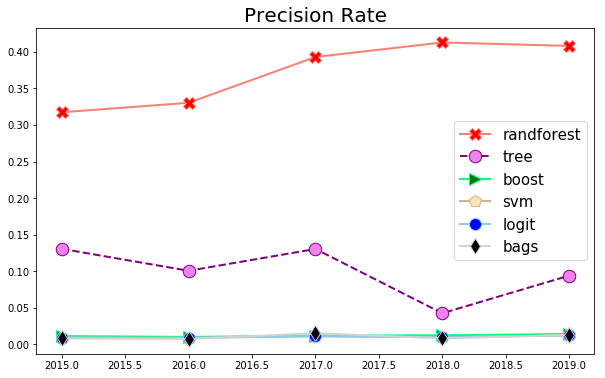

In [53]:
# Data
x = (range(2015,2020))
logistic= df.iloc[:,0]
trees= df.iloc[:,1]
randforests= df.iloc[:,2]
boosting= df.iloc[:,3]
SVM= df.iloc[:,4]
bagging= df.iloc[:,5]
            
 
# multiple line plot
plt.figure(figsize=(10,6))
plt.title("Precision Rate",fontsize=20)
plt.plot( x, randforests, marker='X', markerfacecolor='red', markersize=12,color='salmon', linewidth=2)
plt.plot( x, trees, marker='.',markerfacecolor='violet', markersize=25, color='purple', linewidth=2, linestyle='dashed')
plt.plot( x, boosting, marker='>',markerfacecolor='green', markersize=12, color='springgreen', linewidth=2)
plt.plot( x, SVM, marker='p', markerfacecolor='moccasin', markersize=12,color='tan', linewidth=2)
plt.plot( x, logistic, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=2)
plt.plot( x, bagging, marker='d', markerfacecolor='black', markersize=12,color='lightgrey', linewidth=2)
plt.legend(fontsize=15)


In [38]:
#Rerun random forest, collect each year's results, analyze each random forest's 25 trees

In [89]:
feature_importances = pd.DataFrame(np.round(randforest.feature_importances_,2),
                                   index = x_train.columns,
                                    columns=['Importance']).sort_values('Importance',
                                    ascending=False)

feature_importances

,Importance
AssetLongitude,0.14
AssetLatitude,0.13
Size_Sqft,0.13
YearBuilt,0.12
Long_city,0.08
Lat_city,0.08
PropertyTypeGroup_Healthcare,0.02
PropertyType_Self Storage,0.01
Region_Southwest,0.01
PropertyTypeGroup_Industrial,0.01


In [63]:
# #Visualizing random forest trees
# from sklearn.externals.six import StringIO  
# from IPython.display import Image  
from sklearn.tree import export_graphviz
# import pydotplus
# dot_data = StringIO()
export_graphviz(mdl2, out_file='mytree3',  
                filled=True, rounded=True,
                feature_names=x_train.columns, max_depth=6,proportion=True,rotate=True)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())